## Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## Load Dataset

## California Housing Dataset

### **Overview**
The California Housing dataset contains information about housing prices in various districts of California, based on data from the **1990 U.S. Census**.  

---

### **Dataset Characteristics**
- **Type:** Regression  
- **Samples:** 20,640  
- **Features:** 8 numerical features  
- **Target:** Median house value (in **hundreds of thousands of USD**)  

---

### **Feature Names & Descriptions**
| Feature        | Description |
|----------------|-------------|
| `MedInc`       | Median income in block group (in $10,000s) |
| `HouseAge`     | Median house age in block group |
| `AveRooms`     | Average number of rooms per household |
| `AveBedrms`    | Average number of bedrooms per household |
| `Population`   | Block group population |
| `AveOccup`     | Average number of household members |
| `Latitude`     | Block group latitude |
| `Longitude`    | Block group longitude |

---

### **Target Variable**
- **Name:** `target`  
- **Description:** Median house value in the district (in $100,000s).  
  Example: `2.5` → $250,000


In [2]:
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

In [3]:
print("Features:", list(X.columns))
print("Target:", data.target.name)

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: MedHouseVal


## One Vairable Fit

In [4]:
feature = "MedInc"  # Median income

In [5]:
# Sort by feature for plotting clarity
df = pd.DataFrame({feature: X[feature], "target": y})
df = df.sort_values(by=feature)

In [6]:
# Train/test split
train_errors = []
test_errors = []
sizes = [50, 100, 200, 500, 1000, 5000, len(df)]

In [7]:
for size in sizes:
    X_subset = df[[feature]].iloc[:size]
    y_subset = df["target"].iloc[:size]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y_subset, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_errors.append(train_mse)
    test_errors.append(test_mse)

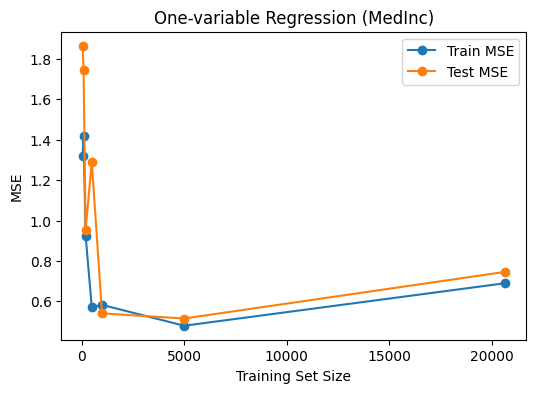

In [8]:
# Plot train/test errors vs dataset size
plt.figure(figsize=(6,4))
plt.plot(sizes, train_errors, label="Train MSE", marker='o')
plt.plot(sizes, test_errors, label="Test MSE", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.title(f"One-variable Regression ({feature})")
plt.legend()
plt.show()

## T-stat and P-value for multiple Vairables

In [9]:
t_stats = []
p_values = []

In [10]:
for col in X.columns:
    X_const = sm.add_constant(X[[col]])
    model = sm.OLS(y, X_const).fit()
    t_stats.append(model.tvalues[col])
    p_values.append(model.pvalues[col])

df_stats = pd.DataFrame({
    "Feature": X.columns,
    "t-stat": t_stats,
    "p-value": p_values
}).sort_values(by="p-value")

In [11]:
print("\nIndividual Feature Significance:")
print(df_stats)


Individual Feature Significance:
      Feature      t-stat        p-value
0      MedInc  136.222508   0.000000e+00
2    AveRooms   22.085232  7.569242e-107
6    Latitude  -20.928580   2.939859e-96
1    HouseAge   15.259144   2.761861e-52
3   AveBedrms   -6.716292   1.912589e-11
7   Longitude   -6.610520   3.923322e-11
4  Population   -3.542232   3.976308e-04
5    AveOccup   -3.411062   6.483442e-04


In [12]:
# -------------------------
# Part 3: Multi-variable fit
# -------------------------
X_const = sm.add_constant(X)
multi_model = sm.OLS(y, X_const).fit()
print("\nMultivariable Regression Summary:")
print(multi_model.summary())

# Identify significant features (p < 0.05)
significant = multi_model.pvalues[multi_model.pvalues < 0.05].index
non_significant = multi_model.pvalues[multi_model.pvalues >= 0.05].index

print("\nSignificant features:", list(significant))
print("Non-significant features:", list(non_significant))


Multivariable Regression Summary:
                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Sat, 23 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:34:42   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.

##  Final Plot using only significant features

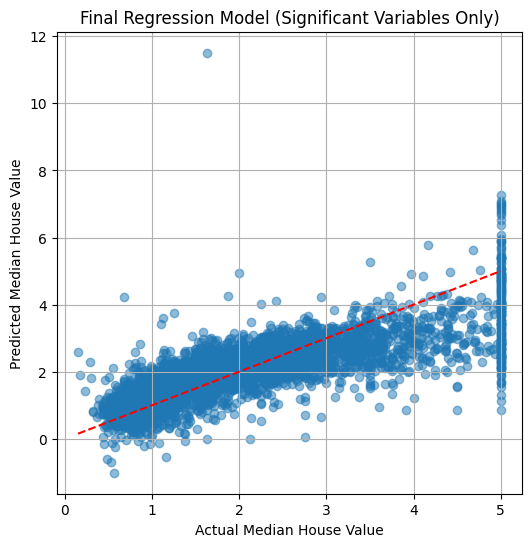

R² Score: 0.5757
RMSE: 0.7456


In [13]:
# Remove the constant term if it exists in the list
significant_features = [f for f in significant if f != "const"]

# Prepare data
X_sig = X[significant_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_sig, y, test_size=0.2, random_state=42
)

# Fit model
final_model = LinearRegression()
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)

# Plot Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Final Regression Model (Significant Variables Only)")
plt.grid(True)
plt.show()

# Print R² and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


## Polynomial Fitting for one variable

### Bias–Variance Trade-off in Polynomial Regression (California Housing)

In this experiment, we fit **polynomial regression models of increasing degree** using
only one feature — `MedInc` (median income) — to predict housing prices.  

- **Training error** (blue) measures how well the model fits the training data.  
- **Test error** (orange) measures how well the model generalizes to unseen data.  

---

#### 🔹 Expected Outcome

1. **Low polynomial degree (1–2):**
   - The model is too simple to capture the true relationship.  
   - Both training and test error are high.  
   - This is the **high bias** regime → the model systematically underfits.

2. **Moderate degree (3–5):**
   - The model becomes flexible enough to capture important nonlinearities.  
   - Training error decreases significantly.  
   - Test error also drops to its **minimum** around this range.  
   - This is the **sweet spot** with a good balance of bias and variance.

3. **High degree (10+):**
   - The model fits the training data almost perfectly, so training error approaches 0.  
   - However, it starts to model random noise in the training data.  
   - Test error rises again — evidence of **overfitting** (high variance).  

---

#### 🔹 Takeaways
- **Bias decreases** as the degree increases, because the model gets more flexible.  
- **Variance increases** at higher degrees, because the model starts reacting too strongly to random fluctuations in the training set.  
- The **bias–variance trade-off** is visible: test error forms a U-shape, being high at both extremes and minimized at an intermediate complexity.  
- This motivates the use of **regularization (Ridge, Lasso)**: it allows us to use flexible models (e.g., degree 15) while penalizing overly large coefficients, reducing variance without adding bias.

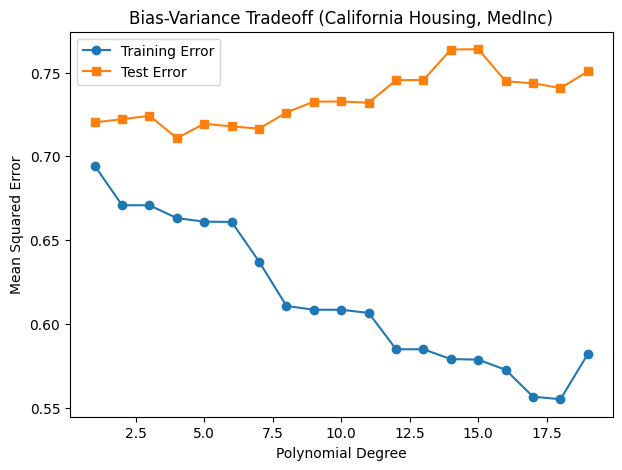

In [14]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Use smaller sample for visible bias-variance effect
X = data.data[["MedInc"]].sample(200, random_state=42).values
y = data.target.sample(200, random_state=42).values

# Scale to avoid huge polynomial values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_errors, test_errors = [], []
degrees = range(1, 20)

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_poly_train, y_train)

    y_train_pred = model.predict(X_poly_train)
    y_test_pred = model.predict(X_poly_test)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Plot training vs test error
plt.figure(figsize=(7,5))
plt.plot(degrees, train_errors, marker='o', label="Training Error")
plt.plot(degrees, test_errors, marker='s', label="Test Error")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.title("Bias-Variance Tradeoff (California Housing, MedInc)")
plt.legend()
plt.show()


In [15]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)  # regularization strength
ridge.fit(X_poly_train, y_train)
ridge_test_error = mean_squared_error(y_test, ridge.predict(X_poly_test))
print("Test error with Ridge (deg=9):", ridge_test_error)


Test error with Ridge (deg=9): 0.7263499497589143


## Comparing R2 values

Polynomial Regression (deg=9):
  Test MSE: 4.6677
  R² Score: 0.1172

Ridge Regression (deg=9, alpha=10):
  Test MSE: 4.6664
  R² Score: 0.1174


C:\Users\Pinak\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.09061e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


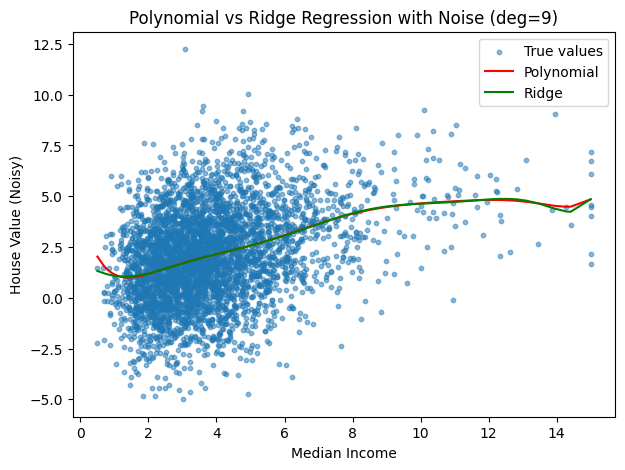

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Use only MedInc feature
X = data.data[["MedInc"]].values
y = data.target.values

# ✅ Add Gaussian noise to y to make the problem noisier
rng = np.random.RandomState(42)
y_noisy = y + rng.normal(0, 2, size=len(y))  # Noise with std dev 5

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=0.2, random_state=42)

# Degree of polynomial
degree = 9
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# ----------------------------
# 1. Plain Polynomial Regression
# ----------------------------
linreg = LinearRegression()
linreg.fit(X_poly_train, y_train)
y_test_pred_poly = linreg.predict(X_poly_test)

poly_mse = mean_squared_error(y_test, y_test_pred_poly)
poly_r2 = r2_score(y_test, y_test_pred_poly)

print(f"Polynomial Regression (deg={degree}):")
print(f"  Test MSE: {poly_mse:.4f}")
print(f"  R² Score: {poly_r2:.4f}")

# ----------------------------
# 2. Ridge Regression
# ----------------------------
ridge = Ridge(alpha=10)   # Regularization strength
ridge.fit(X_poly_train, y_train)
y_test_pred_ridge = ridge.predict(X_poly_test)

ridge_mse = mean_squared_error(y_test, y_test_pred_ridge)
ridge_r2 = r2_score(y_test, y_test_pred_ridge)

print(f"\nRidge Regression (deg={degree}, alpha=10):")
print(f"  Test MSE: {ridge_mse:.4f}")
print(f"  R² Score: {ridge_r2:.4f}")

# ----------------------------
# Compare visually
# ----------------------------
plt.figure(figsize=(7,5))
plt.scatter(X_test, y_test, s=10, label="True values", alpha=0.5)

# Sort X for smooth plotting
X_sorted = np.sort(X_test, axis=0)
X_poly_sorted = poly.transform(X_sorted)

plt.plot(X_sorted, linreg.predict(X_poly_sorted), color="red", label="Polynomial")
plt.plot(X_sorted, ridge.predict(X_poly_sorted), color="green", label="Ridge")

plt.xlabel("Median Income")
plt.ylabel("House Value (Noisy)")
plt.title(f"Polynomial vs Ridge Regression with Noise (deg={degree})")
plt.legend()
plt.show()
